In [1]:
import numpy as np
import pandas as pd
import altair as alt
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from collections import Counter
from imblearn.over_sampling import SMOTE
import keras_tuner as kt

2.7.0


In [2]:
# import dataset from overview
%store -r IMBALANCED_TRAIN_VAL 
%store -r RESAMPLED_TRAIN_VAL 
%store -r TEST 
imbalanced_train_val=IMBALANCED_TRAIN_VAL.copy()
resampled_train_val= RESAMPLED_TRAIN_VAL.copy()
test= TEST.copy()

In [3]:
# display the chape of imbalanced data, resampled data and the test data
print(imbalanced_train_val.shape, 'imbalanced_train_val examples')
print(resampled_train_val.shape, 'resampled_train_val examples')
print(test.shape, 'test examples')

(82332, 43) imbalanced_train_val examples
(370000, 43) resampled_train_val examples
(175341, 43) test examples


In [4]:
# seperate the training and the validation set using train_test_split
# @ 20% validation and 80% trsting
imbalanced_train,imbalanced_val = train_test_split(imbalanced_train_val, test_size=0.2, random_state = 1)
resampled_train,resampled_val = train_test_split(resampled_train_val, test_size=0.2, random_state = 1)
# definr the class of the dataset
CLASSES=['Normal','Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']
#Defination
BATCH_SIZE = 32 # Model batch size
EPOCHS = 100 # Model number of epoch 
MODELS_RESULTS={} # store for all model result for both balanced and resampled datasets
# =====================================================================================
N_TRAIN=len(imbalanced_train)
N_RES_TRAIN=len(resampled_train)
N_VAL=len(imbalanced_val)
N_RES_VAL=len(resampled_val)
N_TEST=len(test)
print('___TEST________________________________________________')
print(test.shape, 'test shape')
print(N_TEST, 'test count')
print('________________________________________________________')
print('___IMBALANCED___________________________________________')
print(imbalanced_train_val.shape, 'training shape')
print(N_TRAIN, 'training examples')
print(N_VAL, 'validation examples')
print('_________________________________________________________')
print('___BALANCED______________________________________________')
print(resampled_train_val.shape, 'training shape')
print(N_RES_TRAIN, 'training examples')
print(N_RES_VAL, 'validation examples')
print('_________________________________________________________')
print(CLASSES)

___TEST________________________________________________
(175341, 43) test shape
175341 test count
________________________________________________________
___IMBALANCED___________________________________________
(82332, 43) training shape
65865 training examples
16467 validation examples
_________________________________________________________
___BALANCED______________________________________________
(370000, 43) training shape
296000 training examples
74000 validation examples
_________________________________________________________
['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']


In [5]:
# five metrics used for evaluation process
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [6]:
# the regularizers for each dence layer
regularizers=tf.keras.regularizers.l2(0.001)
def group_dtype(data):
    # data=data.drop(columns=DROP_COL)
    columns=data.columns # get list of columns
    unique=data.dtypes.unique() # select one of each dtype
    result={'number_col':[],'string_category_col':[],'int_category_col':[],'labels':[]}
    for col in columns:
        if col=='attack_cat': 
            temp= result['labels'] # init array
        elif data[col].dtypes=='float64': 
            temp= result['number_col'] # init array
        elif data[col].dtypes=='int64':
             temp= result['int_category_col'] # init array
        else:
            temp= result['string_category_col'] # init array
        temp.append(col) # append the array
    return result
# p;ot for all result againse epochs
def plot_model_graph(history,name):
    plt.figure(figsize=(8, 30))
    names =['loss','accuracy','precision','recall','prc','auc']
    c=0
    for n in names:
        c=c+1
        n_val = 'val_'+n
        hist = history.history[n]
        hist_val = history.history[n_val]
        plt.subplot(len(names),1,c)
        plt.plot(hist, label='Training {}'.format(n))
        plt.plot(hist_val, label='Validation {}'.format(n))
        plt.legend(loc='lower right')
        plt.ylabel(n)
        plt.ylim(0.4,1)
        plt.title('{} Training and Validation {}'.format(name,n))
    plt.xlabel('epoch')
    return plt
# convert dataprame to tensore datasets
def dataframe_to_dataset(dataframe):
    attack_cat=dataframe.pop('attack_cat')
    x_num=tf.convert_to_tensor(dataframe[number_col])
    x_string=tf.convert_to_tensor(dataframe[string_category_col])
    x_int=tf.convert_to_tensor(dataframe[int_category_col])
    attack_cat = attack_cat.map(CLASSES.index)
    y=tf.keras.utils.to_categorical(attack_cat, num_classes=10)
    return [x_num,x_string,x_int],y

In [7]:
# seperate the structured data into individal type
_col = group_dtype(imbalanced_train) # return result from
number_col=_col['number_col']
string_category_col=_col['string_category_col']
int_category_col=_col['int_category_col']

In [8]:
# ensure all preprosesing  layer adapt to the structure of the dataset 
dataframe = imbalanced_train.copy()
_ds= dataframe_to_dataset(dataframe)
X,y=_ds
input_num_shape = X[0].shape[1:]
input_string_shape = X[1].shape[1:]
input_int_shape = X[2].shape[1:]
classes = 10
# Create a Normalization layer and set its internal state using the training data
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(X[0])
# Create a Intlookup layer and set its internal state using the training data
string_lookup = layers.StringLookup(output_mode="multi_hot")
string_lookup.adapt(X[1])
string_vocabulary=string_lookup.get_vocabulary()
# Create a Intlookup layer and set its internal state using the training data
int_lookup = layers.IntegerLookup( output_mode="multi_hot")
int_lookup.adapt(X[2])
int_vocabulary=int_lookup.get_vocabulary()

In [10]:
# # Load some data
def build_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
   # include the normalization layer
    x1 = normalizer(input_num)
   # Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
   # include the int_lookup layer
    x2 = int_lookup(input_int)
   # Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
   # include the int_lookup layer
    x3 = string_lookup(input_string)
    concat = tf.keras.layers.Concatenate(axis=1)([x1,x2,x3])
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    x = layers.Dense(hp_units_1,activation='relu',kernel_regularizer=regularizers)(concat)
    x = layers.Dropout(0.5)(x)
    
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_2,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_3,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    output = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    print('MODAL-SUMMARY')
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

In [9]:
# model fix, compyling and visualisation 
def evaluation(model,train_ds,val_ds,test_ds,name):
    X_train,y_train=train_ds
    X_val,y_val=val_ds
    X_test,y_test=test_ds
    project_name='HYPERPARAM_'+name
#     Hyperband tuning
    tuner = kt.Hyperband(model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
    
#     early stoppping if val_loss is behaving poorly
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#     hyperparameter search based on 50 epochs
    tuner.search(X_train, y_train, epochs=50, validation_data=[X_val,y_val], callbacks=[stop_early])
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete for {name}. The optimal learning rate for the optimizer
    is {best_hps.get('learning_rate')}.
    """)
    summary=tuner.results_summary(num_trials=1)
    print("summary")
    print(summary)
    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    model = tuner.hypermodel.build(best_hps)
    print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
    history = model.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val,y_val])
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))
#   Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
    hypermodel = tuner.hypermodel.build(best_hps)
    # Retrain the model
    print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
    history = hypermodel.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=best_epoch, validation_data=[X_val,y_val])
    MODELS_RESULTS[name]={}
    print('----')
    print('----')
    print('evaluation result model for:{} on TRAIN_________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_train,y_train)
    MODELS_RESULTS[name]['train']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('evaluation result model for:{} on VALIDATION________________________________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_val,y_val)
    MODELS_RESULTS[name]['validation']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('evaluation result model for:{} on TEST________________________________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_test,y_test)
    MODELS_RESULTS[name]['test']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('plot:{}_________________________________________________________'.format(name))
    plot_model_graph(history,name)
    return hypermodel

Trial 30 Complete [01h 10m 20s]
val_accuracy: 0.8320276737213135

Best val_accuracy So Far: 0.8383433818817139
Total elapsed time: 16h 11m 06s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete for EAIRLY-FUSION-IMBALANCED. The optimal number of units in the first densely-connected
    layer is 128 and the optimal learning rate for the optimizer
    is 0.0001.
    
MODAL-SUMMARY
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                    

2059/2059 [==============================] - 169s 82ms/step - loss: 0.3729 - accuracy: 0.8832 - precision: 0.9459 - recall: 0.8390 - auc: 0.9951 - prc: 0.9665 - val_loss: 0.4791 - val_accuracy: 0.8453 - val_precision: 0.9100 - val_recall: 0.8042 - val_auc: 0.9900 - val_prc: 0.9423
Epoch 42/100
2059/2059 [==============================] - 171s 83ms/step - loss: 0.3712 - accuracy: 0.8833 - precision: 0.9448 - recall: 0.8406 - auc: 0.9951 - prc: 0.9669 - val_loss: 0.4806 - val_accuracy: 0.8425 - val_precision: 0.9159 - val_recall: 0.8012 - val_auc: 0.9899 - val_prc: 0.9425
Epoch 43/100
2059/2059 [==============================] - 171s 83ms/step - loss: 0.3702 - accuracy: 0.8830 - precision: 0.9460 - recall: 0.8400 - auc: 0.9952 - prc: 0.9669 - val_loss: 0.4778 - val_accuracy: 0.8437 - val_precision: 0.9149 - val_recall: 0.8022 - val_auc: 0.9900 - val_prc: 0.9429
Epoch 44/100
2059/2059 [==============================] - 178s 86ms/step - loss: 0.3657 - accuracy: 0.8857 - precision: 0.9477 -

Epoch 69/100
2059/2059 [==============================] - 254s 123ms/step - loss: 0.3348 - accuracy: 0.8952 - precision: 0.9556 - recall: 0.8578 - auc: 0.9962 - prc: 0.9736 - val_loss: 0.4990 - val_accuracy: 0.8425 - val_precision: 0.9072 - val_recall: 0.8034 - val_auc: 0.9882 - val_prc: 0.9391
Epoch 70/100
2059/2059 [==============================] - 227s 110ms/step - loss: 0.3349 - accuracy: 0.8958 - precision: 0.9543 - recall: 0.8568 - auc: 0.9961 - prc: 0.9735 - val_loss: 0.4999 - val_accuracy: 0.8447 - val_precision: 0.9065 - val_recall: 0.8038 - val_auc: 0.9882 - val_prc: 0.9390
Epoch 71/100
2059/2059 [==============================] - 254s 123ms/step - loss: 0.3337 - accuracy: 0.8956 - precision: 0.9559 - recall: 0.8569 - auc: 0.9962 - prc: 0.9737 - val_loss: 0.5024 - val_accuracy: 0.8368 - val_precision: 0.9025 - val_recall: 0.8000 - val_auc: 0.9883 - val_prc: 0.9376
Epoch 72/100
2059/2059 [==============================] - 242s 118ms/step - loss: 0.3318 - accuracy: 0.8980 - pr

2059/2059 [==============================] - 238s 116ms/step - loss: 0.4678 - accuracy: 0.8427 - precision: 0.9181 - recall: 0.7914 - auc: 0.9909 - prc: 0.9420 - val_loss: 0.4854 - val_accuracy: 0.8359 - val_precision: 0.9132 - val_recall: 0.7825 - val_auc: 0.9898 - val_prc: 0.9375
Epoch 11/90
2059/2059 [==============================] - 238s 116ms/step - loss: 0.4633 - accuracy: 0.8441 - precision: 0.9192 - recall: 0.7919 - auc: 0.9911 - prc: 0.9428 - val_loss: 0.4859 - val_accuracy: 0.8348 - val_precision: 0.9115 - val_recall: 0.7842 - val_auc: 0.9897 - val_prc: 0.9373
Epoch 12/90
2059/2059 [==============================] - 240s 116ms/step - loss: 0.4579 - accuracy: 0.8446 - precision: 0.9196 - recall: 0.7937 - auc: 0.9913 - prc: 0.9440 - val_loss: 0.4773 - val_accuracy: 0.8391 - val_precision: 0.9171 - val_recall: 0.7851 - val_auc: 0.9903 - val_prc: 0.9393
Epoch 13/90
2059/2059 [==============================] - 240s 117ms/step - loss: 0.4534 - accuracy: 0.8477 - precision: 0.9217 

Epoch 38/90
2059/2059 [==============================] - 262s 127ms/step - loss: 0.3798 - accuracy: 0.8793 - precision: 0.9429 - recall: 0.8355 - auc: 0.9948 - prc: 0.9647 - val_loss: 0.4773 - val_accuracy: 0.8451 - val_precision: 0.9129 - val_recall: 0.8040 - val_auc: 0.9902 - val_prc: 0.9431
Epoch 39/90
2059/2059 [==============================] - 259s 126ms/step - loss: 0.3768 - accuracy: 0.8807 - precision: 0.9436 - recall: 0.8368 - auc: 0.9949 - prc: 0.9653 - val_loss: 0.4803 - val_accuracy: 0.8451 - val_precision: 0.9098 - val_recall: 0.8016 - val_auc: 0.9899 - val_prc: 0.9421
Epoch 40/90
2059/2059 [==============================] - 261s 127ms/step - loss: 0.3746 - accuracy: 0.8820 - precision: 0.9454 - recall: 0.8387 - auc: 0.9950 - prc: 0.9660 - val_loss: 0.4812 - val_accuracy: 0.8452 - val_precision: 0.9080 - val_recall: 0.8026 - val_auc: 0.9901 - val_prc: 0.9417
Epoch 41/90
2059/2059 [==============================] - 268s 130ms/step - loss: 0.3726 - accuracy: 0.8835 - precis

515/515 [==============================] - 13s 26ms/step - loss: 0.5175 - accuracy: 0.8444 - precision: 0.9001 - recall: 0.8088 - auc: 0.9869 - prc: 0.9371
loss:0.517469048500061 -accuracy:0.844416081905365 - precision:0.9001081585884094 - recall:0.8087690472602844 - auc:0.986932635307312 - prc:0.9370540380477905
----
----
evaluation result model for:EAIRLY-FUSION-IMBALANCED on TEST________________________________________________________________________________
5480/5480 [==============================] - 143s 26ms/step - loss: 0.8111 - accuracy: 0.7648 - precision: 0.8353 - recall: 0.7159 - auc: 0.9691 - prc: 0.8696
loss:0.8111092448234558 -accuracy:0.764784038066864 - precision:0.8353486061096191 - recall:0.7159021496772766 - auc:0.9691238403320312 - prc:0.8695628643035889
----
----
plot:EAIRLY-FUSION-IMBALANCED_________________________________________________________


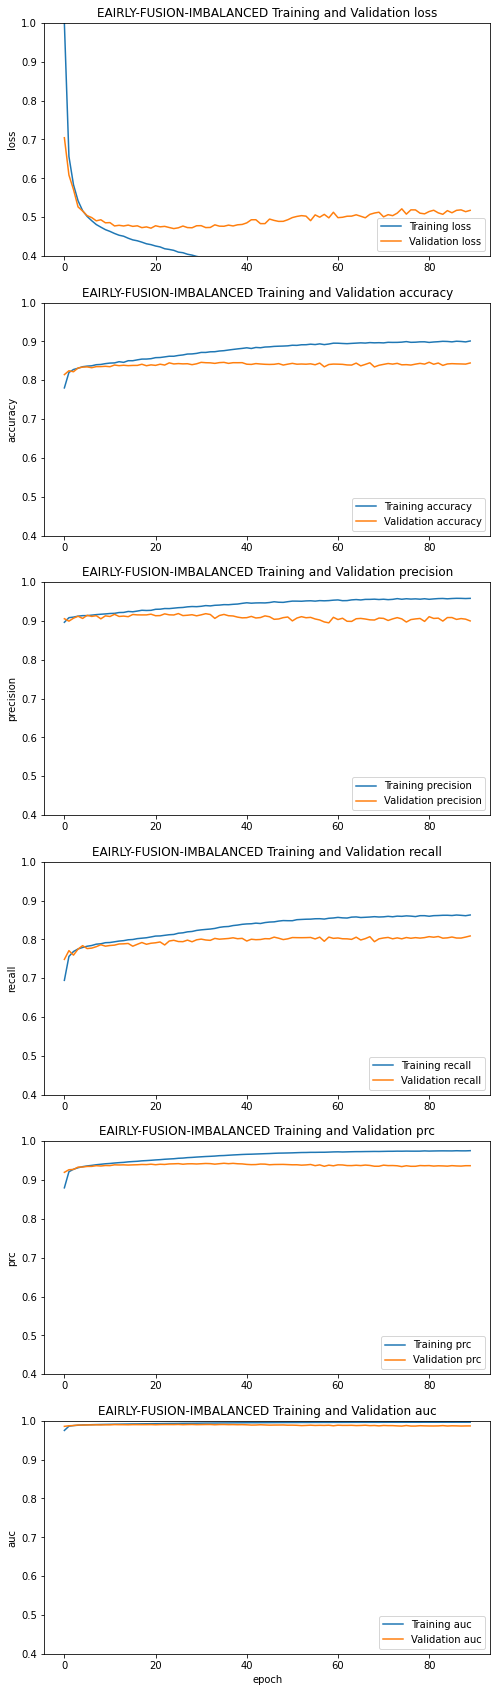

In [11]:
# EAIRLY-FUSION-IMBALANCED
dataframe = imbalanced_train.copy()
train_ds= dataframe_to_dataset(dataframe)
dataframe = imbalanced_val.copy()
val_ds= dataframe_to_dataset(dataframe)
dataframe = test.copy()
test_ds= dataframe_to_dataset(dataframe)

print('EAIRLY-FUSION-IMBALANCED')
model= evaluation(build_model,train_ds,val_ds,test_ds,'EAIRLY-FUSION-IMBALANCED')


Trial 31 Complete [08h 12m 05s]
val_accuracy: 0.7514054179191589

Best val_accuracy So Far: 0.7514054179191589
Total elapsed time: 05h 24m 20s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete for EAIRLY-FUSION-BALANCED. The optimal number of units in the first densely-connected
    layer is 384 and the optimal learning rate for the optimizer
    is 0.0001.
    
MODAL-SUMMARY
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                      

Epoch 42/100
9250/9250 [==============================] - 3025s 327ms/step - loss: 0.6733 - accuracy: 0.7739 - precision: 0.8700 - recall: 0.6799 - auc: 0.9808 - prc: 0.8850 - val_loss: 0.6949 - val_accuracy: 0.7645 - val_precision: 0.8575 - val_recall: 0.6709 - val_auc: 0.9790 - val_prc: 0.8761
Epoch 43/100
9250/9250 [==============================] - 2751s 297ms/step - loss: 0.6732 - accuracy: 0.7746 - precision: 0.8705 - recall: 0.6808 - auc: 0.9808 - prc: 0.8851 - val_loss: 0.6954 - val_accuracy: 0.7622 - val_precision: 0.8469 - val_recall: 0.6774 - val_auc: 0.9791 - val_prc: 0.8750
Epoch 44/100
9250/9250 [==============================] - 2949s 319ms/step - loss: 0.6721 - accuracy: 0.7744 - precision: 0.8699 - recall: 0.6807 - auc: 0.9809 - prc: 0.8853 - val_loss: 0.7055 - val_accuracy: 0.7590 - val_precision: 0.8614 - val_recall: 0.6594 - val_auc: 0.9784 - val_prc: 0.8729
Epoch 45/100
9250/9250 [==============================] - 2908s 314ms/step - loss: 0.6710 - accuracy: 0.7746 

Epoch 70/100
9250/9250 [==============================] - 3493s 378ms/step - loss: 0.6517 - accuracy: 0.7807 - precision: 0.8745 - recall: 0.6910 - auc: 0.9821 - prc: 0.8915 - val_loss: 0.6954 - val_accuracy: 0.7621 - val_precision: 0.8547 - val_recall: 0.6696 - val_auc: 0.9784 - val_prc: 0.8747
Epoch 71/100
9250/9250 [==============================] - 3357s 363ms/step - loss: 0.6517 - accuracy: 0.7819 - precision: 0.8752 - recall: 0.6916 - auc: 0.9820 - prc: 0.8916 - val_loss: 0.6869 - val_accuracy: 0.7655 - val_precision: 0.8616 - val_recall: 0.6689 - val_auc: 0.9793 - val_prc: 0.8778
Epoch 72/100
9250/9250 [==============================] - 3364s 364ms/step - loss: 0.6513 - accuracy: 0.7814 - precision: 0.8743 - recall: 0.6908 - auc: 0.9821 - prc: 0.8916 - val_loss: 0.6863 - val_accuracy: 0.7675 - val_precision: 0.8554 - val_recall: 0.6779 - val_auc: 0.9793 - val_prc: 0.8783
Epoch 73/100
9250/9250 [==============================] - 3333s 360ms/step - loss: 0.6501 - accuracy: 0.7816 

Epoch 98/100
9250/9250 [==============================] - 3164s 342ms/step - loss: 0.6391 - accuracy: 0.7853 - precision: 0.8775 - recall: 0.6987 - auc: 0.9828 - prc: 0.8958 - val_loss: 0.6851 - val_accuracy: 0.7666 - val_precision: 0.8582 - val_recall: 0.6738 - val_auc: 0.9795 - val_prc: 0.8785
Epoch 99/100
9250/9250 [==============================] - 3313s 358ms/step - loss: 0.6372 - accuracy: 0.7857 - precision: 0.8779 - recall: 0.6983 - auc: 0.9830 - prc: 0.8963 - val_loss: 0.6867 - val_accuracy: 0.7673 - val_precision: 0.8595 - val_recall: 0.6732 - val_auc: 0.9793 - val_prc: 0.8784
Epoch 100/100
9250/9250 [==============================] - 3552s 384ms/step - loss: 0.6379 - accuracy: 0.7860 - precision: 0.8780 - recall: 0.6989 - auc: 0.9829 - prc: 0.8963 - val_loss: 0.6855 - val_accuracy: 0.7662 - val_precision: 0.8556 - val_recall: 0.6780 - val_auc: 0.9793 - val_prc: 0.8786
Best epoch: 75
MODAL-SUMMARY
Model: "model_2"
______________________________________________________________

Epoch 13/75
9250/9250 [==============================] - 3126s 338ms/step - loss: 0.7383 - accuracy: 0.7544 - precision: 0.8620 - recall: 0.6462 - auc: 0.9769 - prc: 0.8662 - val_loss: 0.7315 - val_accuracy: 0.7541 - val_precision: 0.8618 - val_recall: 0.6459 - val_auc: 0.9772 - val_prc: 0.8667
Epoch 14/75
9250/9250 [==============================] - 3421s 370ms/step - loss: 0.7335 - accuracy: 0.7560 - precision: 0.8632 - recall: 0.6481 - auc: 0.9772 - prc: 0.8676 - val_loss: 0.7317 - val_accuracy: 0.7541 - val_precision: 0.8610 - val_recall: 0.6470 - val_auc: 0.9771 - val_prc: 0.8663
Epoch 15/75
9250/9250 [==============================] - 3239s 350ms/step - loss: 0.7291 - accuracy: 0.7572 - precision: 0.8630 - recall: 0.6508 - auc: 0.9775 - prc: 0.8689 - val_loss: 0.7355 - val_accuracy: 0.7521 - val_precision: 0.8560 - val_recall: 0.6472 - val_auc: 0.9766 - val_prc: 0.8647
Epoch 16/75
9250/9250 [==============================] - 4053s 438ms/step - loss: 0.7258 - accuracy: 0.7585 - pr

Epoch 41/75
9250/9250 [==============================] - 3258s 352ms/step - loss: 0.6736 - accuracy: 0.7736 - precision: 0.8699 - recall: 0.6803 - auc: 0.9808 - prc: 0.8850 - val_loss: 0.7023 - val_accuracy: 0.7611 - val_precision: 0.8509 - val_recall: 0.6726 - val_auc: 0.9786 - val_prc: 0.8735
Epoch 42/75
9250/9250 [==============================] - 3561s 385ms/step - loss: 0.6722 - accuracy: 0.7739 - precision: 0.8703 - recall: 0.6802 - auc: 0.9809 - prc: 0.8854 - val_loss: 0.6953 - val_accuracy: 0.7621 - val_precision: 0.8501 - val_recall: 0.6769 - val_auc: 0.9790 - val_prc: 0.8756
Epoch 43/75
9250/9250 [==============================] - 3465s 375ms/step - loss: 0.6716 - accuracy: 0.7743 - precision: 0.8707 - recall: 0.6813 - auc: 0.9810 - prc: 0.8856 - val_loss: 0.7047 - val_accuracy: 0.7614 - val_precision: 0.8612 - val_recall: 0.6602 - val_auc: 0.9782 - val_prc: 0.8728
Epoch 44/75
9250/9250 [==============================] - 3528s 381ms/step - loss: 0.6708 - accuracy: 0.7749 - pr

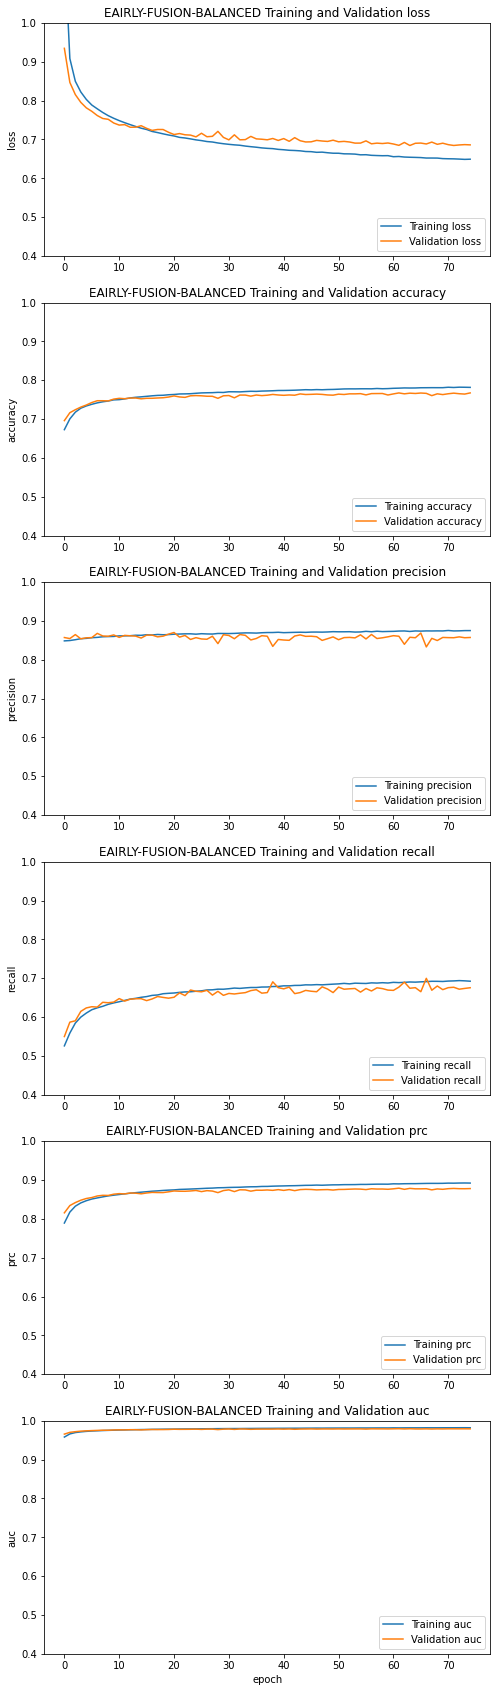

In [13]:
# EAIRLY-FUSION-BALANCED
dataframe = resampled_train.copy()
train_ds= dataframe_to_dataset(dataframe)
dataframe = resampled_val.copy()
val_ds= dataframe_to_dataset(dataframe)
dataframe = test.copy()
test_ds= dataframe_to_dataset(dataframe)
print('EAIRLY-FUSION-BALANCED')
model= evaluation(build_model,train_ds,val_ds,test_ds,'EAIRLY-FUSION-BALANCED')

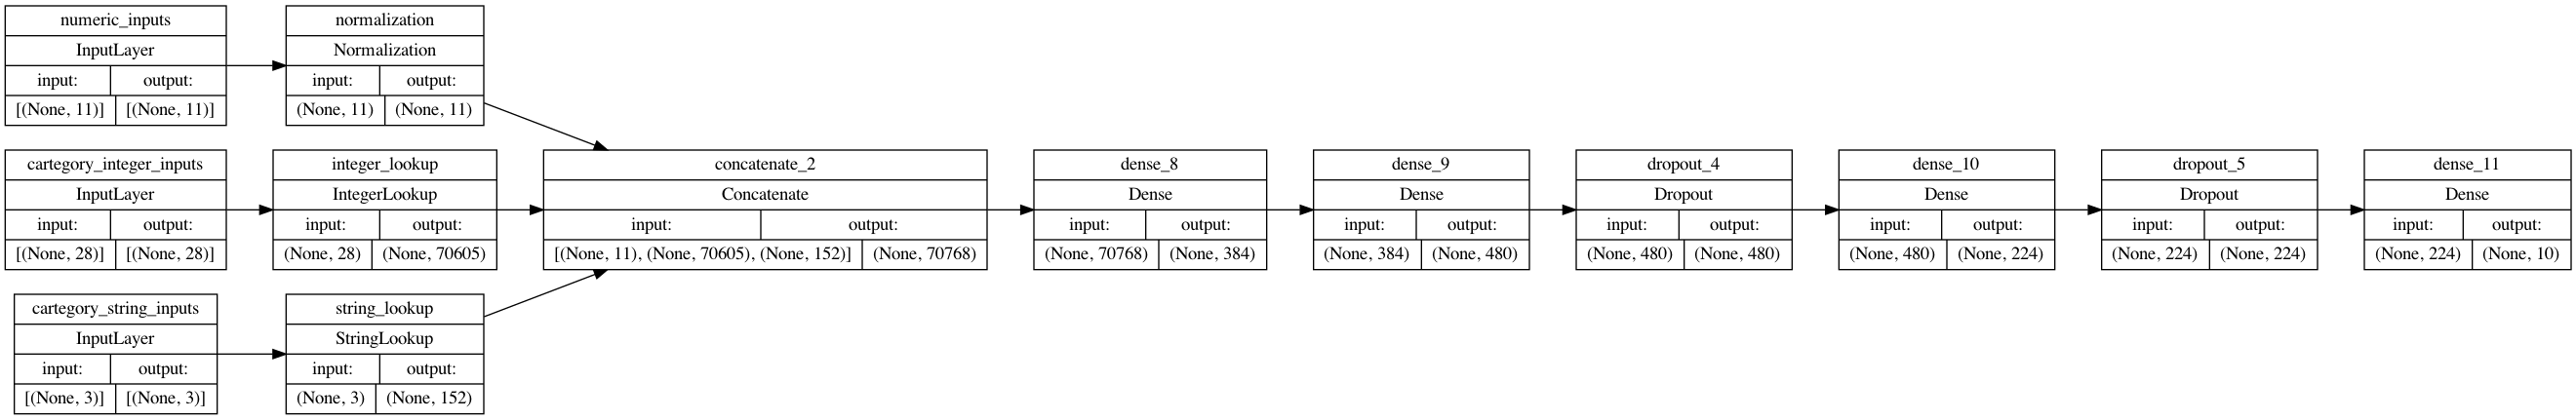

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [16]:
# store result in a file for evaluation process
import pickle
# Step 2
with open('EARLY_FUSION_RESULTS.dictionary', 'wb') as result_dictionary_file:
    pickle.dump(EARLY_FUSION_RESULTS, result_dictionary_file)

In [13]:
project_name='HYPERPARAM_EAIRLY-FUSION-BALANCED'
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
results_summary=tuner.results_summary(num_trials=1)
results_summary

INFO:tensorflow:Reloading Oracle from existing project hyperparam_dir/HYPERPARAM_EAIRLY-FUSION-BALANCED/oracle.json
MODAL-SUMMARY
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                                          
                                                                                                  
 cartegory_string_inputs (Input  [(None, 3)]         0           []                               
 Layer)                                                      